# Import Dependencies

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Set Constant

In [3]:
BATCH_SIZE = 32
CHANNELS = 3
IMAGE_SIZE = 255
EPCHOS = 50

# Import Data

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/cropped-image-of-celebrity',
    seed = 123,
    shuffle = True,
    image_size= (IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 168 files belonging to 5 classes.


In [6]:
class_names = dataset.class_names
class_names

['lionel_messi',
 'maria_sharapova',
 'roger_federer',
 'serena_williams',
 'virat_kohli']

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    
    print(labels_batch.numpy())

(32, 255, 255, 3)
[3 0 0 4 4 1 4 4 0 4 1 1 4 0 1 2 0 0 0 4 4 2 3 0 0 4 4 0 3 4 4 2]


# Data Visualization

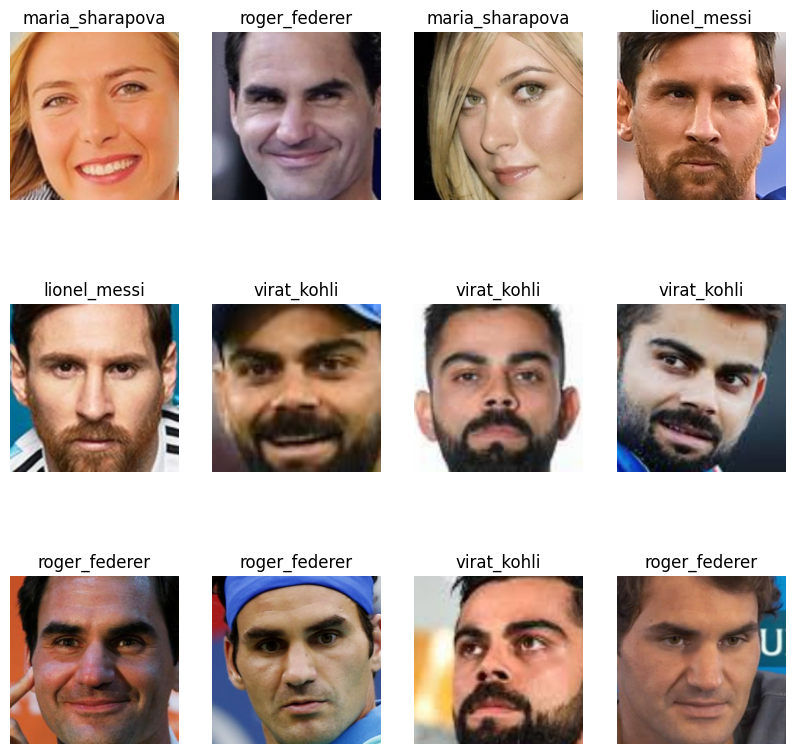

In [8]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch  in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i + 1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[labels_batch[i]])
        plt.axis('off')
    plt.show()

# Split Dataset

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

4

In [18]:
len(test_ds)

2

In [19]:
len(val_ds)

0

Shuffling

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

# Resizing

In [21]:
resize_and_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(0.1 / 256)
])

#  Data AUgmentation

In [22]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

appling data augmentation on train dataset

In [23]:
train_ds  = train_ds.map(
    lambda x,y: (data_augmentation(x, training = True), y),
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Arcgutecture

In [35]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 8

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size= (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
    
])
model.build(input_shape=input_shape)

In [42]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False
)

In [36]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 255, 255, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (32, 253, 253, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 126, 126, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 124, 124, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [37]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy']
             )

In [43]:
history= model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=500,
    callbacks=callback)

Epoch 1/500
4/4 [==============================] - 1s 194ms/step - loss: 0.6656 - accuracy: 0.7596
Epoch 2/500
4/4 [==============================] - 1s 203ms/step - loss: 0.8007 - accuracy: 0.6923
Epoch 3/500
4/4 [==============================] - 1s 211ms/step - loss: 0.6576 - accuracy: 0.7500
Epoch 4/500
4/4 [==============================] - 1s 197ms/step - loss: 0.6673 - accuracy: 0.7500
Epoch 5/500
4/4 [==============================] - 1s 209ms/step - loss: 0.6419 - accuracy: 0.7500
Epoch 6/500
4/4 [==============================] - 1s 204ms/step - loss: 0.6177 - accuracy: 0.7404
Epoch 7/500
4/4 [==============================] - 1s 205ms/step - loss: 0.6521 - accuracy: 0.7212
Epoch 8/500
4/4 [==============================] - 1s 299ms/step - loss: 0.6694 - accuracy: 0.7019
Epoch 9/500
4/4 [==============================] - 1s 282ms/step - loss: 0.5772 - accuracy: 0.7692
Epoch 10/500
4/4 [==============================] - 1s 194ms/step - loss: 0.6453 - accuracy: 0.7308
Epoch 11/

In [44]:
model.evaluate(test_ds)

2/2 [==============================] - 0s 28ms/step - loss: 0.1700 - accuracy: 0.9062


[0.1699533760547638, 0.90625]

In [45]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 22ms/step


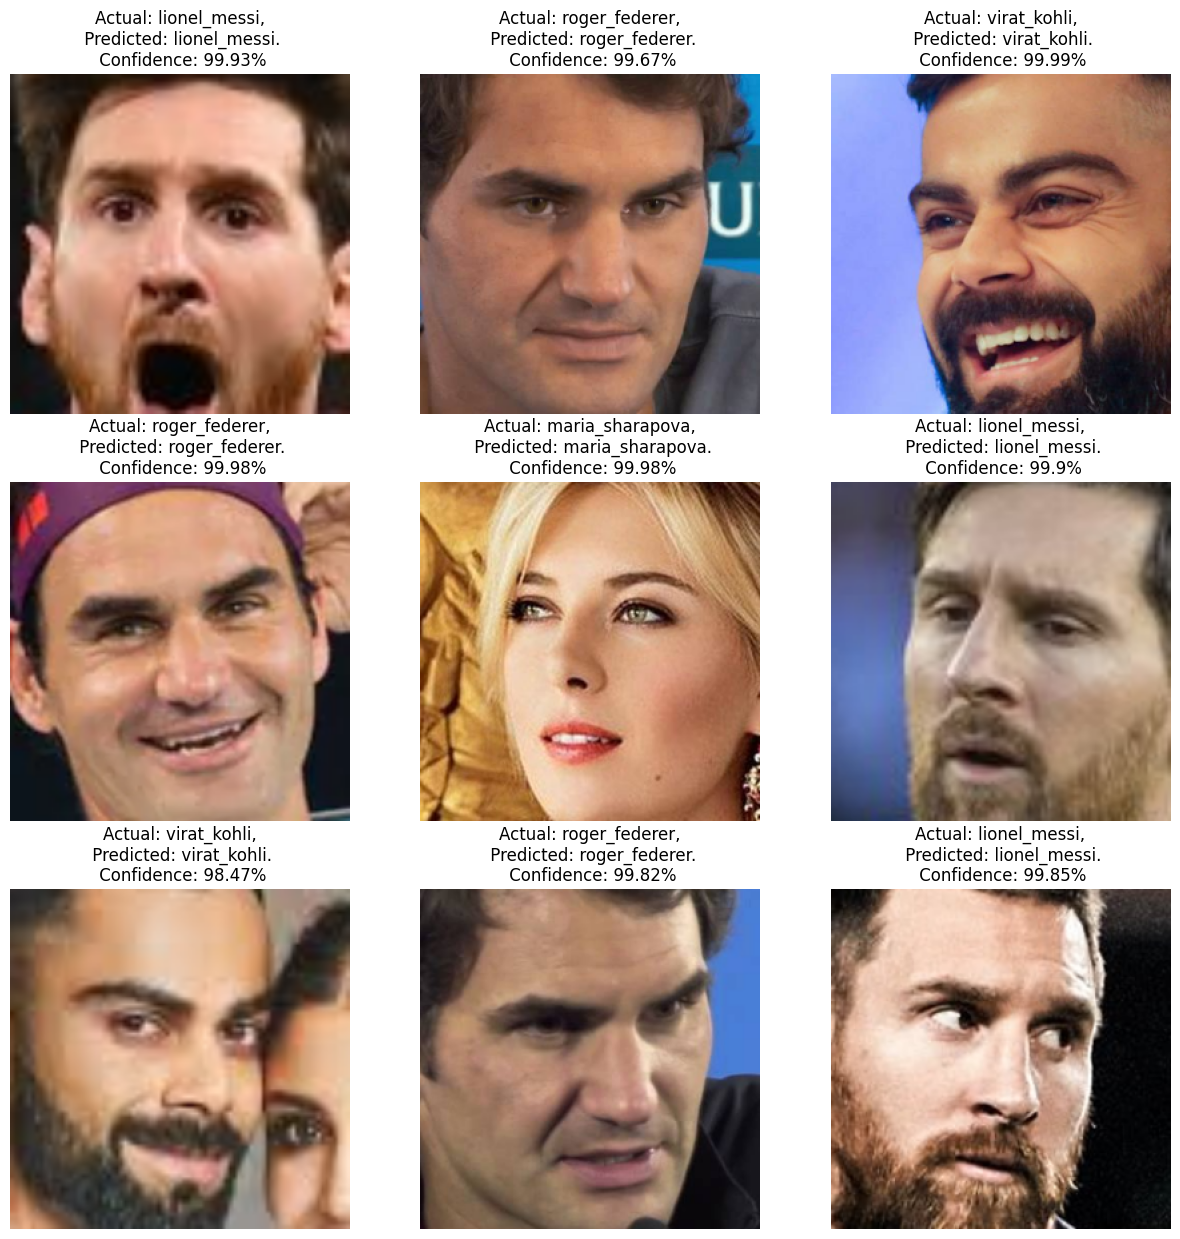

In [46]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [47]:
import os

# List comprehension to filter out non-integer entries
model_versions = [int(i) for i in os.listdir("/kaggle/working/") if i.isdigit()]

# Get the maximum version or default to 0 if the list is empty
model_version = max(model_versions, default=0) + 1

model.save(f"/kaggle/working/{model_version}")

In [48]:
import shutil
# from google.colab import files

# Specify the folder path on Kaggle
folder_path_on_kaggle = "/kaggle/working/1"

# Specify the local destination path for the zip file
local_zip_destination = "downloaded_folder.zip"

# Create a zip file of the folder
shutil.make_archive(local_zip_destination[:-4], 'zip', folder_path_on_kaggle)

'/kaggle/working/downloaded_folder.zip'